In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

___
# EXPLORATORY DATA ANLYIS (EDA)

## Load the data

In [2]:
# Read the data
data = pd.read_csv("results.csv", delimiter = ',')

# Clean the column names by replacing non-breaking spaces with regular spaces
data.columns = data.columns.str.replace('\xa0', ' ')

# Detect NaN values
nan_mask = data.isna()
#nan_mask

# Remove rows with NaN values in the 'Cluster Size (mm3)' column
data = data.dropna(subset=['Cluster Size (mm3)'])

# Calculate the Euclidean distance from each coordinate point to the origin
data['Modulus'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

data.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3),class,Modulus
0,7.345247,-15.866709,56.949326,6.063923,612.0,0.0,59.572904
1,69.700568,-45.257200,31.309791,7.057335,235.0,0.0,88.807017
2,-46.328400,-12.654834,37.308468,6.507323,188.0,0.0,60.814367
3,11.159777,-28.086391,70.011730,6.181728,188.0,0.0,76.256333
4,-13.138064,-80.154294,-24.429830,11.170099,9011.0,1.0,84.818254


In [3]:
# Convert columns to numeric
columns_to_convert = ['X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)', 'class','Modulus']
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

In [4]:
data.describe()

,X,Y,Z,Peak Stat,Cluster Size (mm3),class,Modulus
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,4.752402,-44.642246,26.313125,8.695709,14261.652174,1.034783,80.566448
std,37.723701,43.222148,29.910423,1.646610,29780.358084,0.815749,19.225602
min,-65.150143,-111.208794,-40.390247,5.935638,188.000000,0.000000,30.096304
25%,-29.240533,-77.603429,11.518155,7.378318,1703.000000,0.000000,70.981844
50%,10.060849,-45.257200,27.078006,8.388586,3548.000000,1.000000,83.066271
75%,38.080439,-15.046399,48.418556,9.828912,10078.500000,2.000000,94.538242
max,69.700568,75.130151,77.486183,12.674675,167639.000000,2.000000,114.822359


## EDA 

### Joint histograms 

In [5]:
################### CHOOSE, DON´T PUT ALL OF THEM

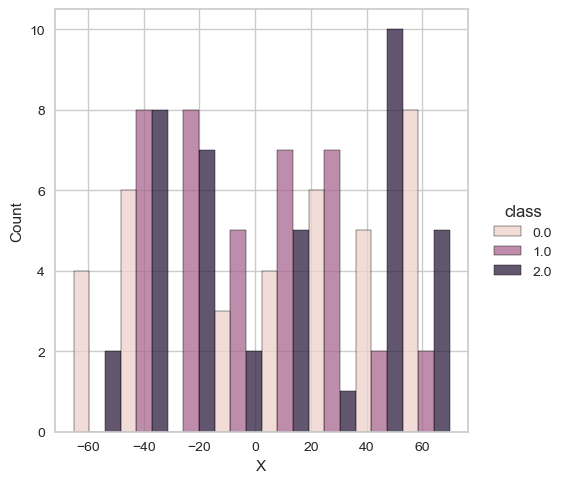

In [6]:
sns.displot(data, x="X", hue="class", multiple="dodge",
            facet_kws={'despine': False});

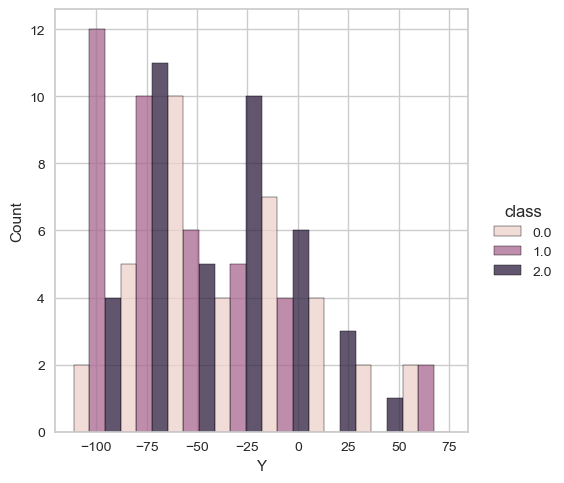

In [7]:
sns.displot(data, x="Y", hue="class", multiple="dodge",
            facet_kws={'despine': False});

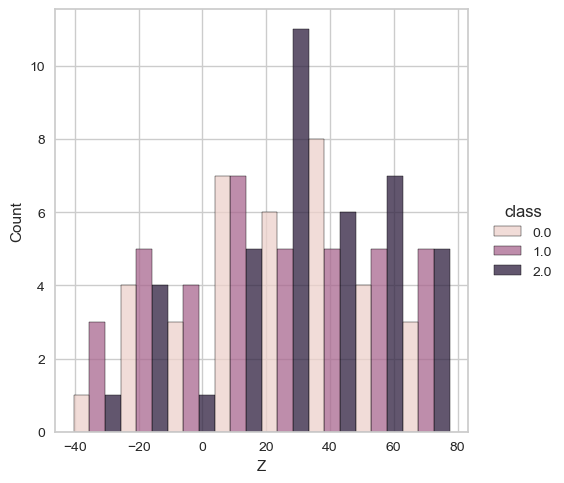

In [8]:
sns.displot(data, x="Z", hue="class", multiple="dodge",
            facet_kws={'despine': False});

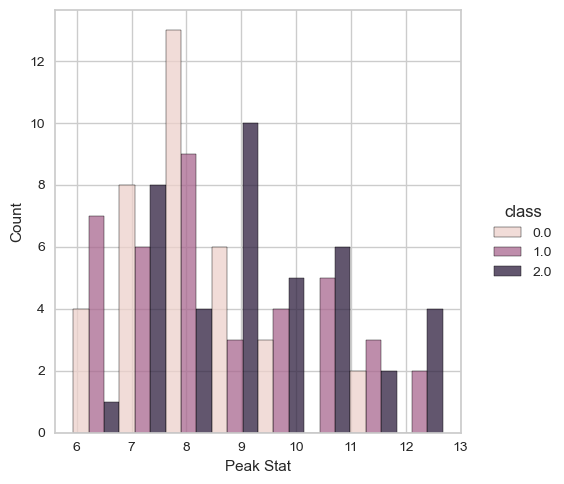

In [9]:
sns.displot(data, x="Peak Stat", hue="class", multiple="dodge",
            facet_kws={'despine': False});

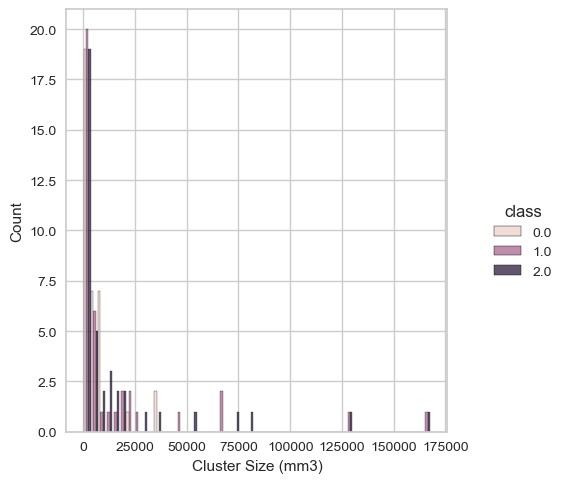

In [10]:
sns.displot(data, x="Cluster Size (mm3)", hue="class", multiple="dodge",
            facet_kws={'despine': False});

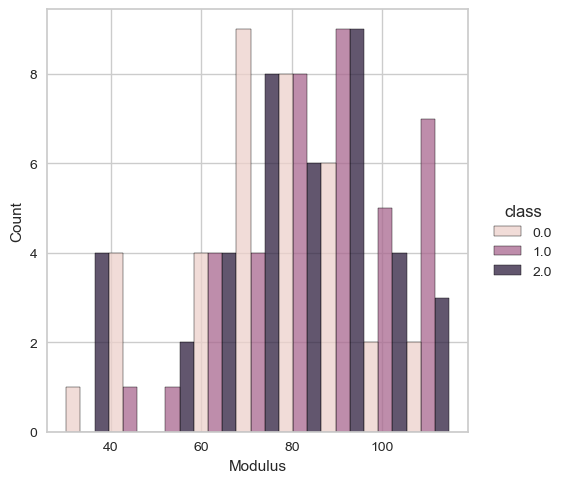

In [11]:
sns.displot(data, x="Modulus", hue="class", multiple="dodge",
            facet_kws={'despine': False});

### Destimation

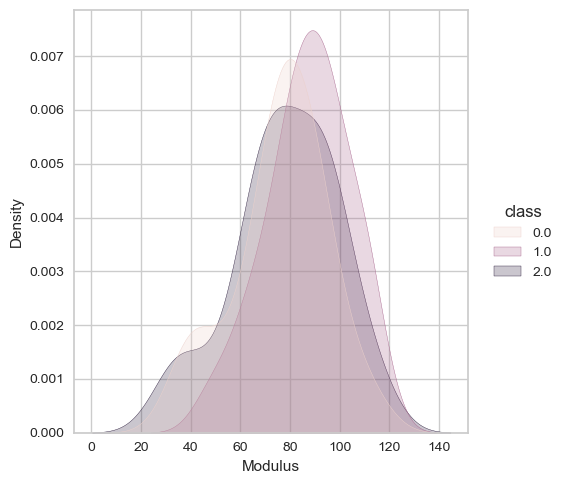

In [12]:
sns.displot(data, x="Modulus", hue="class", kind="kde",
            fill=True, facet_kws={'despine': False});

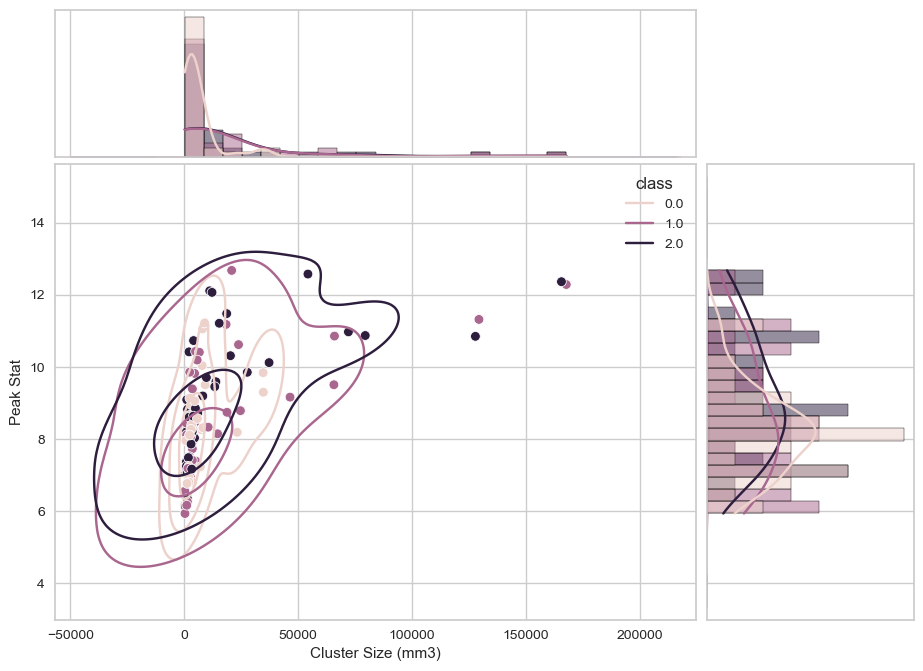

In [13]:
g = sns.jointplot(data=data, x="Cluster Size (mm3)", y="Peak Stat", hue="class", ratio=3, space=0.05)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

### Multiple distributions

In [14]:
# # pairplot
# g = sns.pairplot(data, hue="class", grid_kws={'despine': False})
# g.map_upper(sns.kdeplot, levels=5, alpha=0.5)
# g.map_diag(sns.histplot, binwidth=0.25, kde=True, fill=True);

Data should be balanced, but in order to avoid larger features to dominate among others some feature scaling has been performed.

### Correlation matrix¶

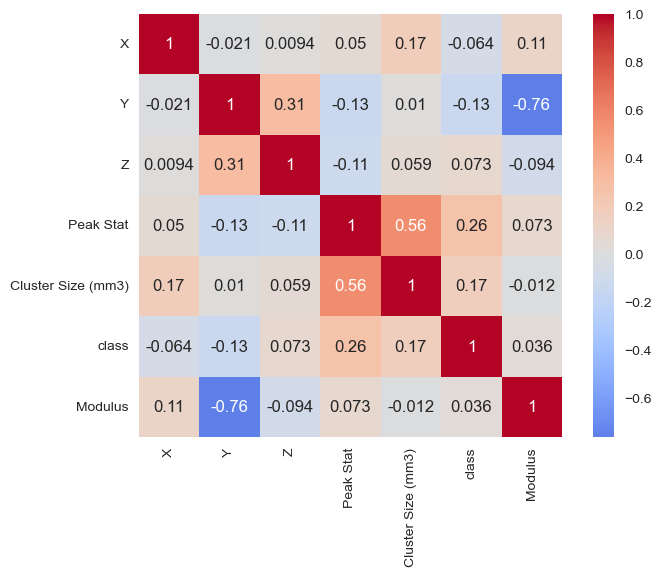

In [15]:
corrmat = data.corr(numeric_only=True)
sns.heatmap(corrmat, annot=True, square=True, cmap="coolwarm", center=0);

### Parallel coordinate plots

In [16]:
### no he puesto en cual es el hue, que queiro que coja el class!!!

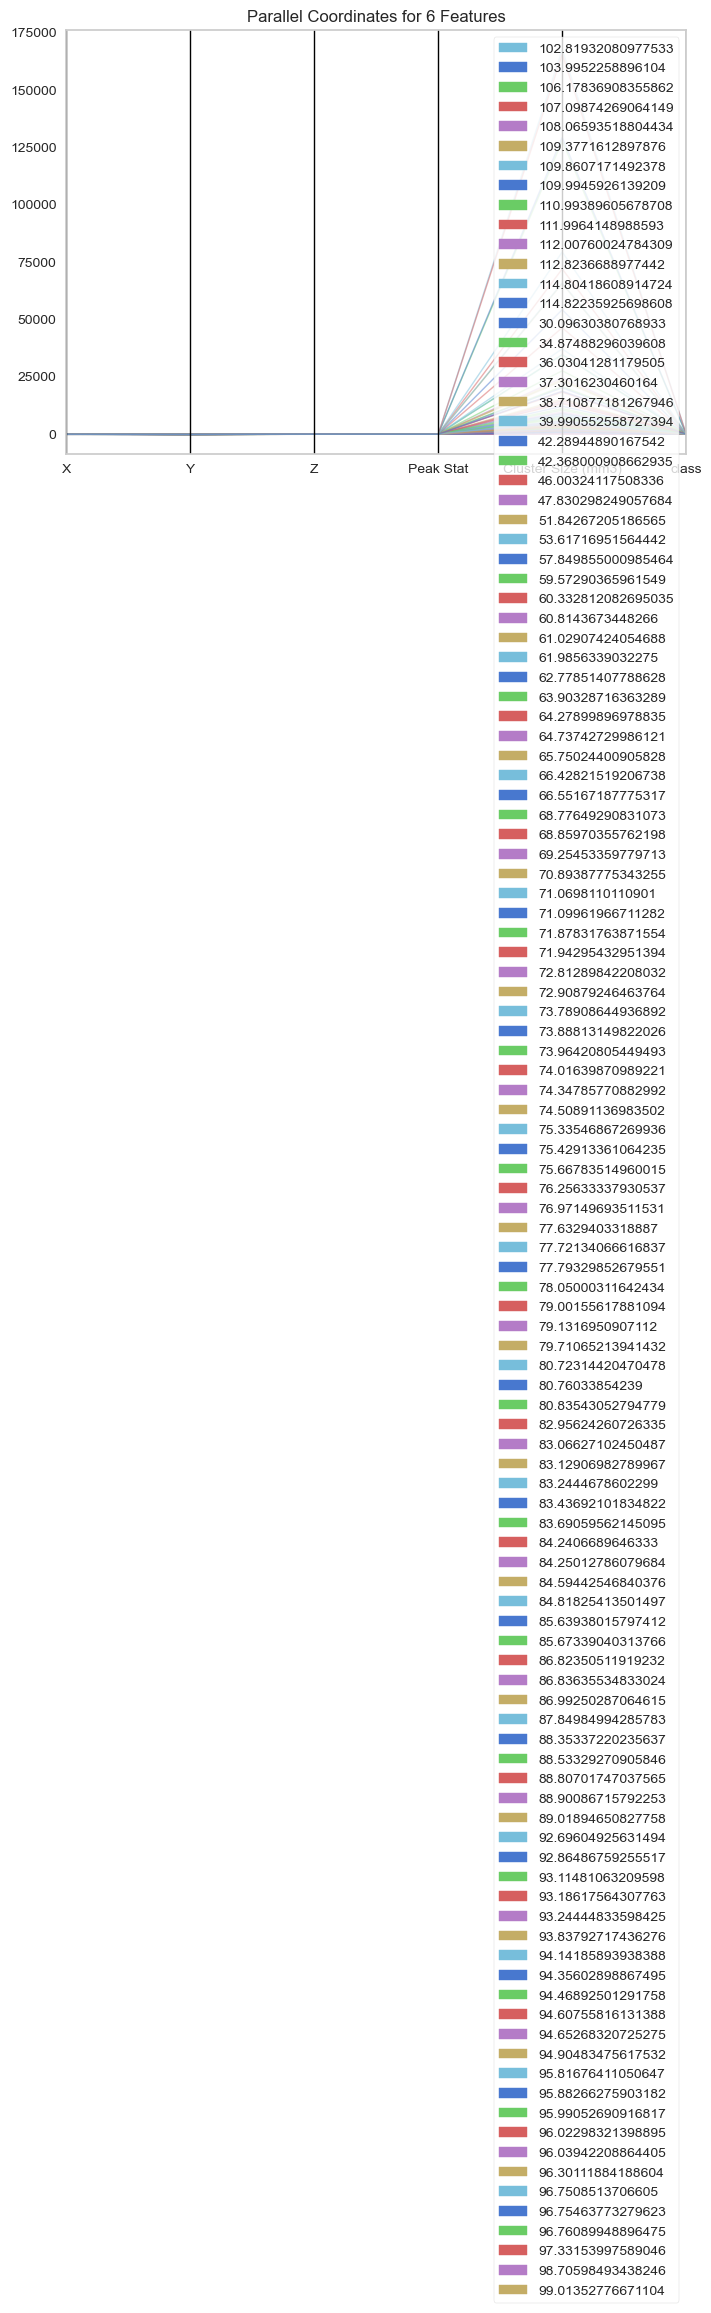

In [17]:
from yellowbrick.features import ParallelCoordinates
from yellowbrick.style import set_palette
set_palette('sns_muted')

# Instantiate the visualizer
visualizer = ParallelCoordinates(features=data.columns[0:-1],
                                 fast=True)
# Fit and transform the data to the visualizer
visualizer.fit_transform(data.iloc[:, 0:-1], data.iloc[:, -1])
# Finalize the title and axes then display the visualization
visualizer.show();

---
# CLUSTERING

## Feature scaling

For data unbalance 

In [18]:
# Divide dataset into features and target
X = data[['X', 'Y', 'Z', 'Peak Stat','Cluster Size (mm3)','Modulus']]
y = data[['class']]

In [19]:
# Feature scaled
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [20]:
# Convert to dataframe
df_hfo_PAT1_st = pd.DataFrame(X_scaled,columns=X.columns)
df_hfo_PAT1_st = pd.concat([df_hfo_PAT1_st, y], axis=1)

## Elbow Method - Optimal number of clusters

The Elbow Method is useful to detect the optimum number of clusters required to divide each specific dataset. This can be done withouth huge level of coding.  

  File "C:\Users\Ferran\anaconda3\envs\data_analysis\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


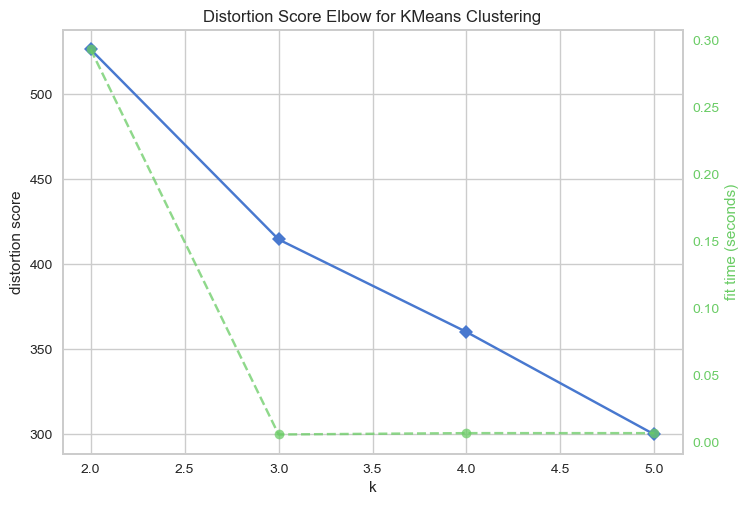

In [21]:
km = KMeans(n_init="auto")
elbow = KElbowVisualizer(km, k=(2, 6))
elbow.fit(X_scaled)
elbow.show();

Once we know the optimum k number of clusters, we can proceed with the different algorithms that have to be followed. If we want to visualize if the clustering division is performed on a balanced way between the different groups,some silhuette plots can be performed. 

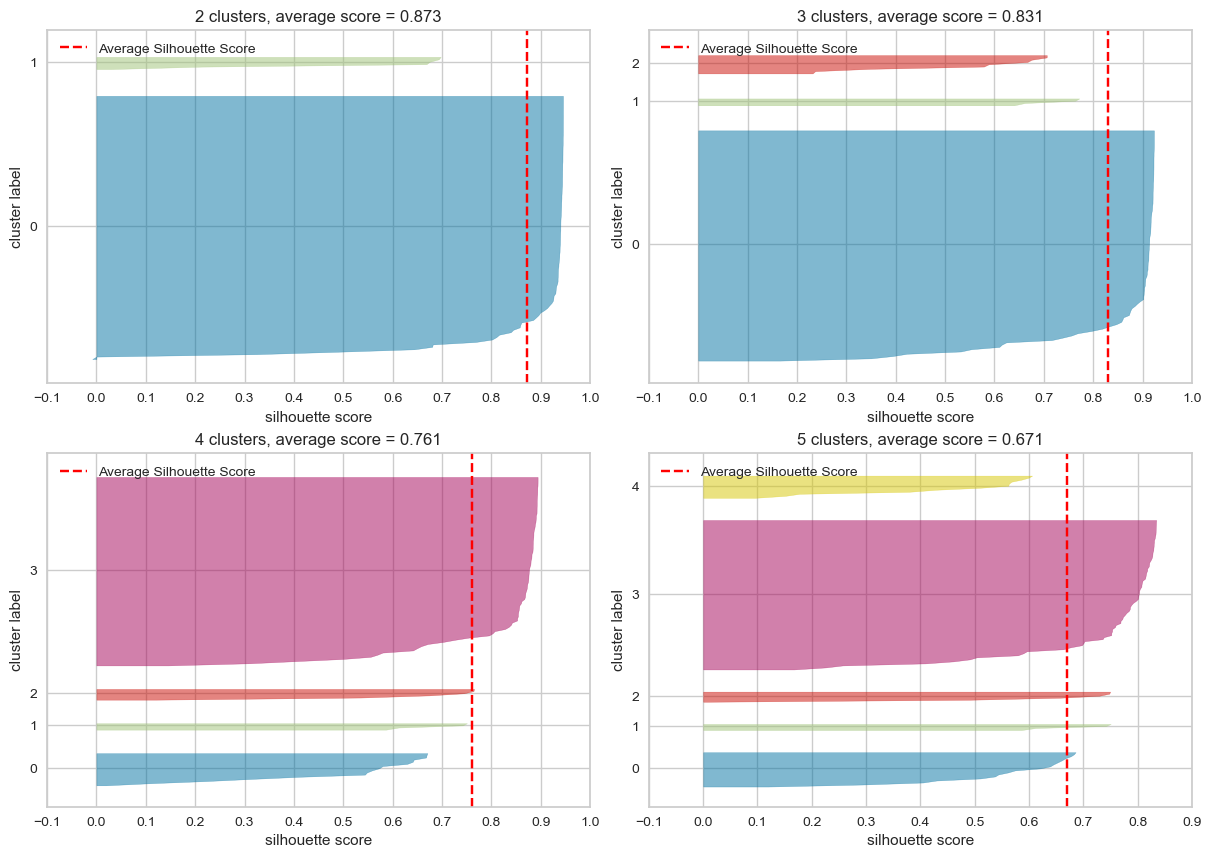

In [22]:
# Set figure layout
fig4 = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = fig4.add_gridspec(3, 2)
ax411 = fig4.add_subplot(gs[0, 0])
ax412 = fig4.add_subplot(gs[0, 1])
ax413 = fig4.add_subplot(gs[1, 0])
ax421 = fig4.add_subplot(gs[1, 1])
ax_list = [ax411, ax412, ax413, ax421]

# Evaluate silhouette plots for 2 to 5 clusters
for i, n_clusters in enumerate(range(2, 6)):
    km = KMeans(n_clusters, n_init="auto", random_state=42)
    viz = SilhouetteVisualizer(km, ax=ax_list[i],
                               colors='yellowbrick')
    viz.fit(X)
    viz.finalize()
    viz.ax.set_title(
        f"{n_clusters} clusters, average score = {viz.silhouette_score_:0.3f}")
    viz.ax.set_xlabel("silhouette score")

### Conclusion for our data

## ALGORITHM TRIALS

### K-Means

In [23]:
# Define the mapping from numeric labels to string labels
label_map = {0.0: 'EEG', 1.0: 'EEG+fMRI', 2.0: 'fMRI'}

# Map the numeric labels to string labels
data['class_str'] = data['class'].map(label_map)

# Adjusted plotting function
def plot_data_clusters(ax, data, x, y, hue, title, *args):
    if not args or (args and args[0]):
        sns.kdeplot(data=data,
                    x=x, y=y,
                    hue=hue,
                    alpha=0.5,
                    levels=3,
                    palette="deep",
                    ax=ax)
    sns.scatterplot(data=data,
                    x=x, y=y,
                    hue=hue,
                    palette="deep",
                    ax=ax)
    ax.set_title(title, size=14)


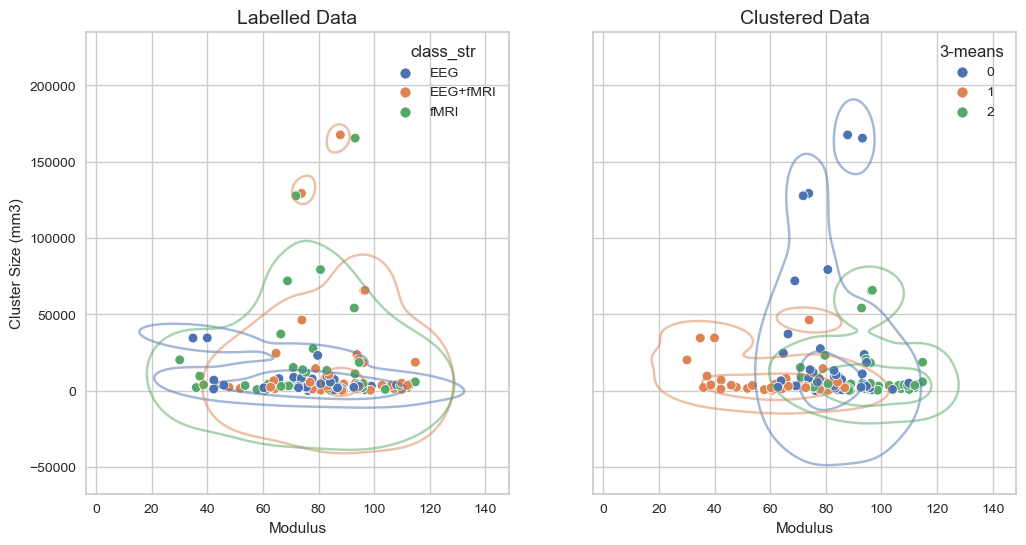

In [24]:
# Fit clustering and extract assigned clusters
km3 = KMeans(n_clusters=3, n_init="auto", random_state=42)
km3.fit(X_scaled)
data['3-means'] = km3.labels_

# Create a figure to compare labels and clusters
fig1, (ax11, ax12) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax11, data, 'Modulus', 'Cluster Size (mm3)', 'class_str', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax12, data, 'Modulus', 'Cluster Size (mm3)', '3-means', 'Clustered Data')

# Show the plot
plt.show()

### Hierarchical clustering

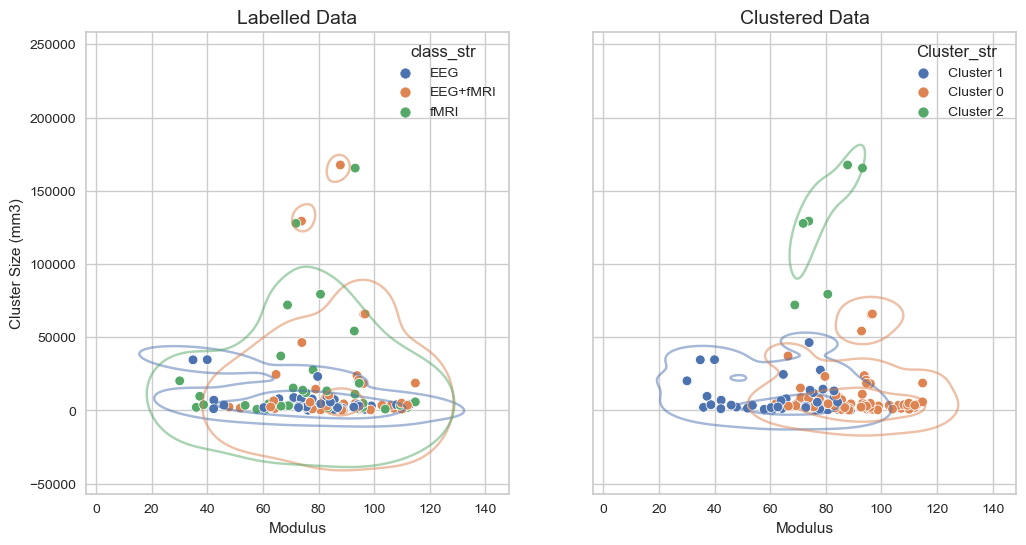

In [25]:
# REMEMBER TO CHANGE THE NUMBER OF CLUSTERS ACCORDING TO THE OPTIMUM NUMBER THAT HAS
#BEEN OBTAINED PREVIOUSLY
agg = AgglomerativeClustering(n_clusters=3,
                              metric='euclidean',
                              linkage='ward')
agg.fit(X_scaled)

# Create a figure to compare labels and clusters
fig5, (ax51, ax52) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax51, data, 'Modulus', 'Cluster Size (mm3)', 'class_str', 'Labelled Data')

# Add clustering labels to the dataset for plotting
data['Cluster'] = agg.labels_

# Map clusters to labels for the hue in the plot (if needed, otherwise use numbers directly)
cluster_label_map = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'}
data['Cluster_str'] = data['Cluster'].map(cluster_label_map)

# Plot clustered data
plot_data_clusters(ax52, data,  'Modulus', 'Cluster Size (mm3)', 'Cluster_str', 'Clustered Data')

# Show the plot
plt.show()

### Density-based clustering

This method detectsareas with a large amount of samples closely together.

#### DBSCAN

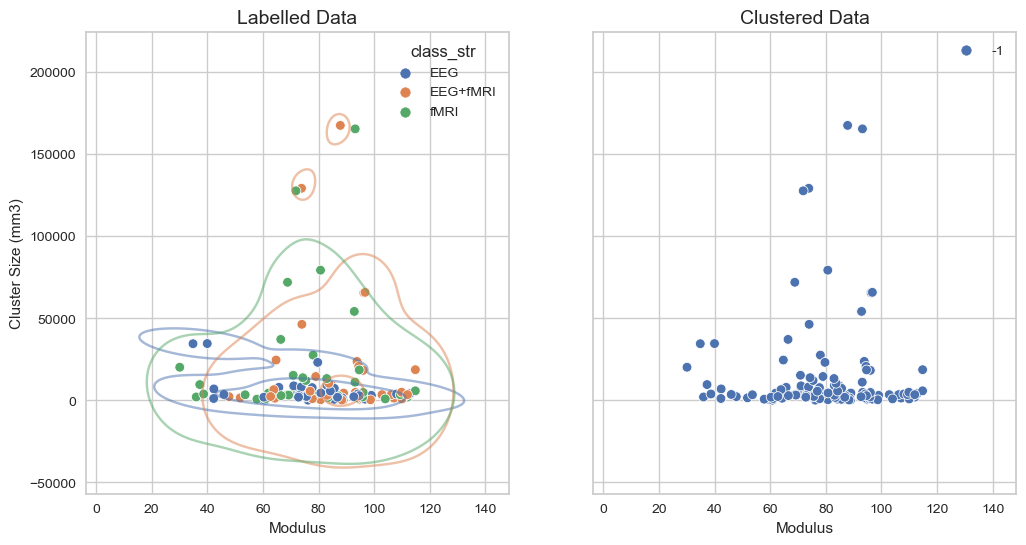

In [26]:
# Fit DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=15)
dbscan.fit(X_scaled)

# Create a figure to compare labels and clusters
fig6, (ax61, ax62) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax61, data,  'Modulus', 'Cluster Size (mm3)', 'class_str', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax62, data,  'Modulus', 'Cluster Size (mm3)', dbscan.labels_, 'Clustered Data', False)

plt.show()

#### OPTICS

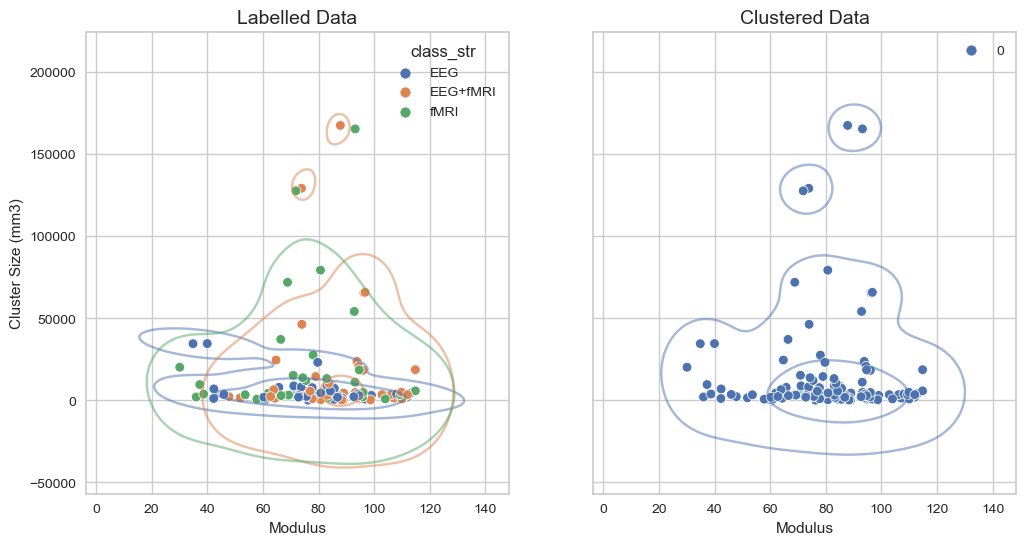

In [27]:
# Fit OPTICS clustering
optics = OPTICS(min_samples=15, xi=0.15, min_cluster_size=0.15)
optics.fit(X_scaled)

# Create a figure to compare labels and clusters
fig6, (ax61, ax62) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax61, data, 'Modulus', 'Cluster Size (mm3)', 'class_str', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax62, data,  'Modulus', 'Cluster Size (mm3)', optics.labels_, 'Clustered Data')

# Show the plot
plt.show()

TAKE INTO ACCOUNT THAT IT SHOULD RETURN THE SAME NUMBER OF CLUSTERS AS WHAT WE HAVE DEFINED AS OPTIMUM! IF IT'S NOT THE CASE, WE MUST AVOID THESE METHODS

---
# CLASSIFICATION

### Train - test Spitting 

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pathlib import Path

from yellowbrick.model_selection import ValidationCurve, LearningCurve, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from yellowbrick.classifier import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [29]:
# # target
# y = data['class']

# # data
# X = data[['X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)', 'Modulus']]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Divide dataset into train and test subsets
train_data, test_data = train_test_split(data, test_size=0.4, stratify=data['class'], random_state=42)
print(data.shape)
print(test_data.shape)

(115, 11)
(46, 11)


In [31]:
X_train = train_data[['X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)', 'Modulus']]
y_train = train_data['class']
X_test = test_data[['X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)', 'Modulus']]
y_test = test_data['class']

In [32]:
def study_model(model, X, y, param_name,param_range):
    
    sizes = np.linspace(0.1, 1.0, 10)    
        
    # Validation curve

    vc = ValidationCurve(
        model, param_name=param_name,
        param_range=param_range, cv=10, scoring="r2"
    )
       
        
    vc.fit(X, y)
    vc.show()

    # Learning Curve
    lc = LearningCurve(
        model, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
    )

    lc.fit(X, y)
    lc.show()           

    return model

In [33]:
def binary_classification(model, X_train, y_train, X_test, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train, y_train).predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate evaluation metrics
    cm = confusion_matrix(model,
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      is_fitted=True,
                      support=True,
                      cmap='RdYlGn')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Display results
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Roc AUC score:", roc_auc)
    
    # Roc curve
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
        
    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model

## LDA

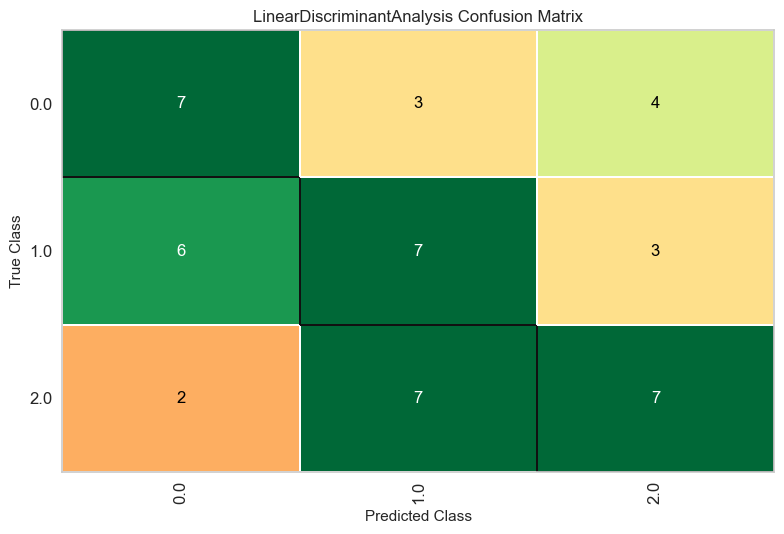

              precision    recall  f1-score   support

         0.0       0.50      0.47      0.48        15
         1.0       0.44      0.41      0.42        17
         2.0       0.44      0.50      0.47        14

    accuracy                           0.46        46
   macro avg       0.46      0.46      0.46        46
weighted avg       0.46      0.46      0.46        46



In [34]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report


# Instanciate model
lda_2 = LinearDiscriminantAnalysis()

# Train model, use it to predict
selected_predictors = ['Cluster Size (mm3)', 'Modulus']
y_pred = lda_2.fit(X_train[selected_predictors], y_train).predict(X_test[selected_predictors])

cm = confusion_matrix(lda_2,
                      X_train[selected_predictors],
                      y_train,
                      X_test[selected_predictors],
                      y_test,
                      is_fitted=True,
                      support=True,
                      cmap='RdYlGn')

# Classification report
print(classification_report(y_pred, y_test))

### ROC and precision-call curves 

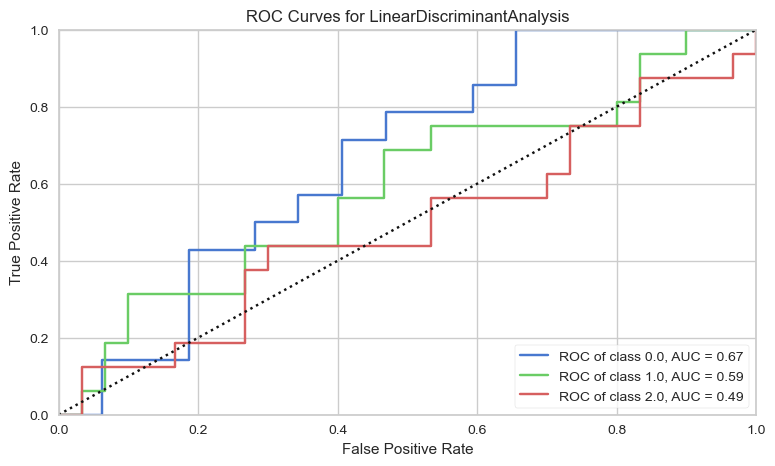

In [35]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve


# Fit visualizer to our classifier
roc_viz = ROCAUC(lda_2,
                 is_fitted=True,
                 per_class=True,
                 micro=False,
                 macro=False,
                 size=(900, 500))
roc_viz.fit(X_train[selected_predictors], y_train)
roc_viz.score(X_test[selected_predictors], y_test)
roc_viz.show();

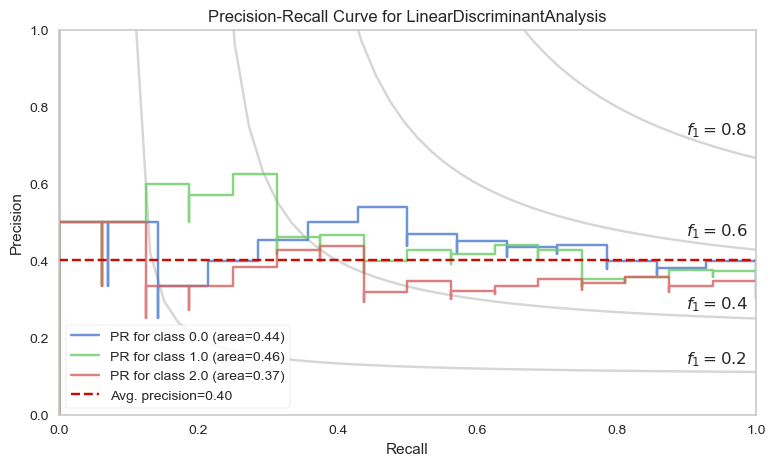

In [36]:
from sklearn.preprocessing import LabelEncoder


# Encode the target (we'll use the encoder to retrieve the class labels)
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)

# Create the visualizer
pr_viz = PrecisionRecallCurve(lda_2,
                              classes=encoder.classes_,
                              iso_f1_curves=True,
                              per_class=True,
                              micro=False,
                              size=(900, 500))

# Fit model (we need one-versus-rest classifiers
# to produce binary comparisos for each class)
pr_viz.fit(X_train[selected_predictors], y_train)

# Calculate scores and show them
pr_viz.score(X_test[selected_predictors], y_test)
pr_viz.show();

In [37]:
lda_2 = LinearDiscriminantAnalysis()
lda_2.fit(X_train[selected_predictors].values, encoded_y_train)
y_pred = lda_2.predict(X_test[selected_predictors].values)

'Cluster Size (mm3)', 'Modulus'

N = 300
X = np.linspace(np.floor(min(X_train["Cluster Size (mm3)"])) - 0.2,
                np.ceil(max(X_train["Cluster Size (mm3)"]))+0.2,
                N)
Y = np.linspace(np.floor(min(X_train["Modulus"])) - 0.2,
                np.ceil(max(X_train["Modulus"]))+0.2,
                N)
X, Y = np.meshgrid(X, Y)

g = sns.FacetGrid(test_data,
                  hue="Type",
                  height=5).map(plt.scatter,
                               "Cluster Size (mm3)",
                                "Modulus").add_legend()
zz = np.array([lda_2.predict(np.array([[xx, yy]]))
              for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = zz.reshape(X.shape)

# Plot the filled and boundary contours
g.ax.contourf(X, Y, Z, 2, alpha=.1, colors=('blue', 'orange', 'green'))
g.ax.contour(X, Y, Z, 2, alpha=1, colors=('blue', 'orange', 'green'))

# Add axis and title
g.ax.set_xlabel('Cluster Size (mm3)')
g.ax.set_ylabel('Modulus (coordinates- origin)')
g.ax.set_title('LDA Decision Boundaries with Test Data')
g.fig.set_figheight(8)
g.fig.set_figwidth(12)

KeyError: 'Type'

## Naive bayes

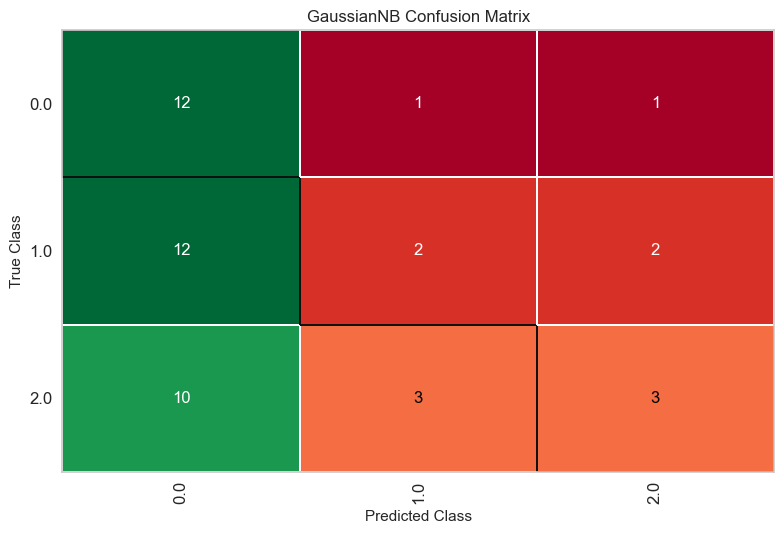

              precision    recall  f1-score   support

         0.0       0.86      0.35      0.50        34
         1.0       0.12      0.33      0.18         6
         2.0       0.19      0.50      0.27         6

    accuracy                           0.37        46
   macro avg       0.39      0.40      0.32        46
weighted avg       0.67      0.37      0.43        46



In [38]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train, y_train).predict(X_test)

    cm = confusion_matrix(model,
                          X_train,
                          y_train,
                          X_test,
                          y_test,
                          is_fitted=True,
                          support=True,
                          cmap='RdYlGn')

    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model


# Evaluate model
evaluate_classifier(GaussianNB(), X_train, y_train, X_test, y_test);

## Logistic regression

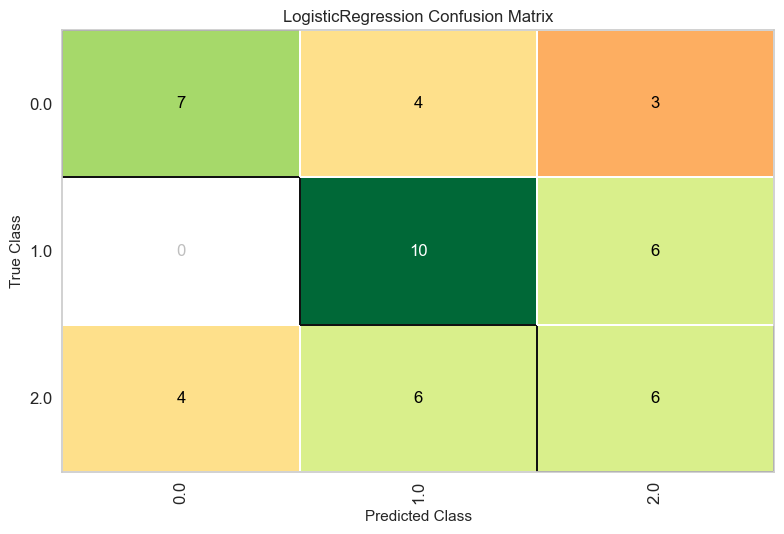

              precision    recall  f1-score   support

         0.0       0.50      0.64      0.56        11
         1.0       0.62      0.50      0.56        20
         2.0       0.38      0.40      0.39        15

    accuracy                           0.50        46
   macro avg       0.50      0.51      0.50        46
weighted avg       0.51      0.50      0.50        46



In [39]:
# lr = LogisticRegression(solver='liblinear')
# study_model(lr, X, y, 'C',np.linspace(0.1, 1, 20))
# binary_classification(lr, X_train, y_train, X_test, y_test)

evaluate_classifier(LogisticRegression(solver='newton-cg'),
                    X_train,
                    y_train,
                    X_test,
                    y_test);

## KNN

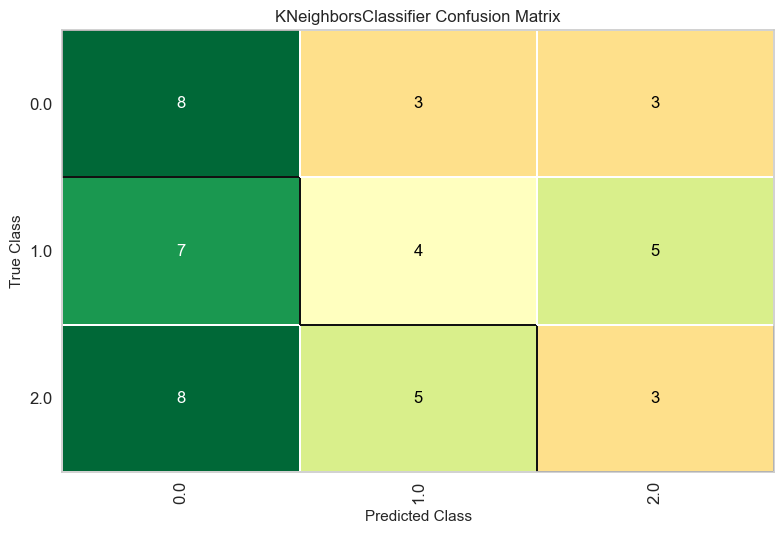

              precision    recall  f1-score   support

         0.0       0.57      0.35      0.43        23
         1.0       0.25      0.33      0.29        12
         2.0       0.19      0.27      0.22        11

    accuracy                           0.33        46
   macro avg       0.34      0.32      0.31        46
weighted avg       0.40      0.33      0.34        46



In [40]:
# knn = KNeighborsClassifier(n_neighbors=10)
# study_model(knn, X, y, 'n_neighbors',np.arange(1, 11))
# binary_classification(knn, X_train, y_train, X_test, y_test)


evaluate_classifier(KNeighborsClassifier(n_neighbors=10),
                    X_train,
                    y_train,
                    X_test,
                    y_test);


## Decision Tree

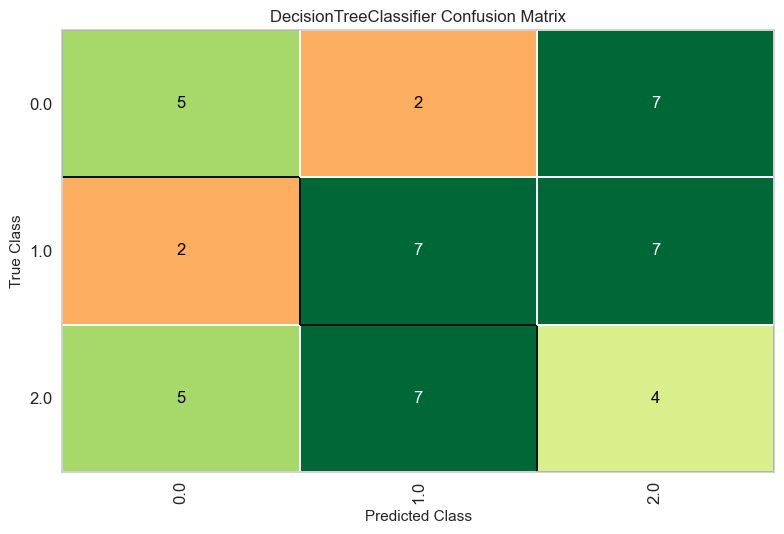

              precision    recall  f1-score   support

         0.0       0.36      0.42      0.38        12
         1.0       0.44      0.44      0.44        16
         2.0       0.25      0.22      0.24        18

    accuracy                           0.35        46
   macro avg       0.35      0.36      0.35        46
weighted avg       0.34      0.35      0.34        46



In [41]:
# Confusion matrix
dt = evaluate_classifier(DecisionTreeClassifier(max_depth=3, random_state=42),
                    X_train,
                    y_train,
                    X_test,
                    y_test);

## Random Forest

In [42]:
# rf = RandomForestClassifier(max_depth=2, random_state=0)
# study_model(rf, X, y, 'max_depth',np.arange(1, 11))
# binary_classification(rf, X_train, y_train, X_test, y_test)

with plt.style.context('default'):  # a silly bug makes us do this to see the tree
    plt.figure(figsize=(12, 8))
    plot_tree(dt,
              impurity=True,
              feature_names=X_train.columns,
              class_names=encoder.classes_,
              fontsize=14,
              rounded=True,
              filled=True)

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)', 'Modulus'], dtype='object') instead.

<Figure size 1200x800 with 0 Axes>

## Support Vector Machine

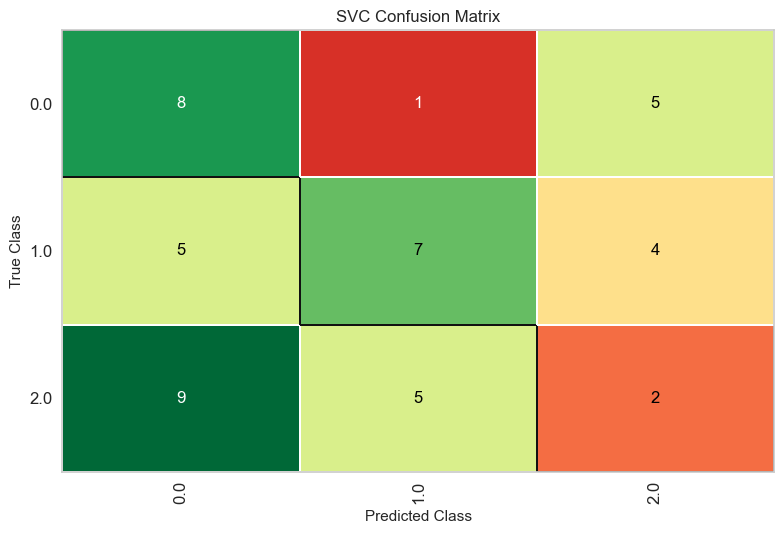

              precision    recall  f1-score   support

         0.0       0.57      0.36      0.44        22
         1.0       0.44      0.54      0.48        13
         2.0       0.12      0.18      0.15        11

    accuracy                           0.37        46
   macro avg       0.38      0.36      0.36        46
weighted avg       0.43      0.37      0.38        46



In [43]:
# svm_ = SVC(kernel='linear',probability=True)
# study_model(svm_, X, y, 'gamma',np.logspace(-3, 3, 10))
# binary_classification(svm_, X_train, y_train, X_test, y_test)


# Confusion matrix
evaluate_classifier(SVC(kernel='linear'),
                    X_train,
                    y_train,
                    X_test,
                    y_test);